# Building up Data Pipelines using Apache Airflow 
### Data Engineering Capstone Project

#### Project Summary
The main goal of the capstone project is to create a Data Lake in S3 and a DWH in Redshift using Data Pipeline orchestrating tool - Apache Airflow

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import re
import os
import configparser
import boto3
from io import StringIO
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

config = configparser.ConfigParser()
config.read('./dwh.cfg')

AWS_ACCESS_KEY = config.get('AWS', 'AWS_KEY_ID')
AWS_SECRET = config.get('AWS','AWS_SECRET')
AWS_REGION = config.get('AWS','REGION')
S3_BUCKET = config.get('S3','RAW_DATA_BUCKET')

os.environ["AWS_ACCESS_KEY_ID"]= AWS_ACCESS_KEY
os.environ["AWS_SECRET_ACCESS_KEY"]= AWS_SECRET

spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11,org.apache.hadoop:hadoop-aws:2.7.2").enableHiveSupport().getOrCreate()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
from pyspark.sql.functions import from_unixtime, unix_timestamp, to_date, expr,\
                                  date_add,udf,col,avg,mean,year,month,split,lit
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import StringType, DateType

### Step 1: Project Scope and Data Gathering

The scope of the project is to create a Data Lake which could be accessible for the Data Scientists and a DWH which
could be accessed by Data Analysts who are interested in providing deeper insights into US immigration. Main focus areas include
the issued visa types and the immigrant profiles associated with it.

**Data Sources from Udacity**
- **I94 Immigration Data**: This data comes from the US National Tourism and Trade Office found [here](https://travel.trade.gov/research/reports/i94/historical/2016.html). Each report contains international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries)
- **U.S. City Demographics Data**: This dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. Dataset comes from OpenSoft found [here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).
- **Airport Codes**: This is a simple table of airport codes and corresponding cities. The airport codes may refer to either IATA airport code, a three-letter code which is used in passenger reservation, ticketing and baggage-handling systems, or the ICAO airport code which is a four letter code used by ATC systems and for airports that do not have an IATA airport code (from wikipedia). It comes from [here](https://datahub.io/core/airport-codes#data)
**External Data Sources**
I have enriched the dataset using the following data sources to make the analysis more useful and more informative

- **Port of Entry/Nationality Codes**: This dataset contains information about various of port of entry codes which would be used to join the data in the I94 immigration data. The nationality codes contain the country abbreviations [Port Codes; Nationality Codes And Port of Entry codes](https://fam.state.gov/fam/09FAM/09FAM010205.html)
- **US Visa Types**: This data is extracted from the US DHS and Wikipedia which would give information on various visa types offered by US [US Non-immigrant Visa Types](https://www.dhs.gov/immigration-statistics/nonimmigrant/NonimmigrantCOA) and [US Immigrant Visa Types](https://en.m.wikipedia.org/wiki/Visa_policy_of_the_United_States#Classes_of_visas)
- **Airline Codes**: This data source consists of airlines IATA abbreviations and the country of origin [Airline Codes](https://www.iata.org/en/about/members/airline-list?page=30&search=&ordering=Alphabetical)

In the following sections I will explore various data sets needed for the project

#### 1. Exploring the I94 Data

In [3]:
# Read in the data here
df_i94_sample = pd.read_csv('./data/immigration_data_sample.csv')

In [4]:
df_i94_sample.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,20573.0,61.0,2.0,1.0,20160422,NaN,NaN,G,O,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,20568.0,26.0,2.0,1.0,20160423,MTR,NaN,G,R,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,20571.0,76.0,2.0,1.0,20160407,NaN,NaN,G,O,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,20581.0,25.0,2.0,1.0,20160428,DOH,NaN,G,O,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,20553.0,19.0,2.0,1.0,20160406,NaN,NaN,Z,K,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


**Observations:** 
- The columns in the immigration data are encoded. Therefore these columns could be Foreign Keys in the Fact table
- To create the corresponding Dimension Tables the `SAS_Label_Descriptions` file will be used to extract them into `csv` files which will be stored in `meta_data` folder

#### 1.1 Extracting meta data from i94 immigration data label Descriptions

***Extracting Raw Data***

In [464]:
# Reading the Label Description file and extracting information which can form dimensional tables later
with open('./data/I94_SAS_Labels_Descriptions.SAS') as i94_descritpion:
    i94_label_content = i94_descritpion.read()

In [18]:
text = re.search(r'value i94cntyl.*? ;', i94_label_content, re.DOTALL).group()
text=text.split('\n')

In [19]:
i94cit_i94res = pd.DataFrame(columns=['i94_code','country_name'])

In [20]:
i94cit_i94res['i94_code'] = [code.split('=')[0].strip() for code in text[1:]]
i94cit_i94res['country_name'] = [code.split('=')[1].rstrip(' ;').replace("'","") for code in text[1:]]

In [21]:
i94cit_i94res.head(10)

,i94_code,country_name
0,582,"MEXICO Air Sea, and Not Reported (I-94, no l..."
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA
5,324,ANGOLA
6,529,ANGUILLA
7,518,ANTIGUA-BARBUDA
8,687,ARGENTINA
9,151,ARMENIA


**Observation:** This data can be used to map the country codes to their respective names

In [22]:
text = re.search(r'i94prtl.*?;', i94_label_content, re.DOTALL).group()
text=text.split('\n')

In [23]:
i94port_i94code = pd.DataFrame(columns=['i94_port_code','i94_airport_location','i94_airport_state'])

In [24]:
i94port_i94code['i94_port_code'] = [re.search('[A-Z](?=)\w+', code).group() for code in text[1:-1]]
i94port_i94code['i94_airport_location'] = [re.findall('\'(.*?),', code.split('\t=\t')[1])[0] if len(re.findall('\'(.*?),', code.split('\t=\t')[1]))>0 else code.split('\t=\t')[1].strip(" '") 
                                           for code in text[1:-1]]

In [25]:
i94port_i94code['i94_airport_state'] = [code.split('\t=\t')[1].strip(" '") for code in text[1:-1]]
i94port_i94code['i94_airport_state'] = i94port_i94code['i94_airport_state'].str.split(', ')
i94port_i94code['i94_airport_state'] = [code[-1] for code in i94port_i94code['i94_airport_state']]

In [26]:
for code in i94port_i94code.i94_airport_state:
    if len(code)>2 and 'Collapsed' not in code and 'No PORT Code' not in code:
        tmp = code.split(' ')
        if len(tmp)>1:
            if len(tmp[0])==2 and '(BPS)' in tmp[1] or '#ARPT' in tmp[1]:
                i94port_i94code.loc[i94port_i94code.i94_airport_state==code,'i94_airport_state'] = tmp[0]

            if len(tmp[1]) == 2 and len(tmp[0])!=2:
                i94port_i94code.loc[i94port_i94code.i94_airport_state==code,'i94_airport_state'] = tmp[1]

In [27]:
i94port_i94code.head(10)

,i94_port_code,i94_airport_location,i94_airport_state
0,ALC,ALCAN,AK
1,ANC,ANCHORAGE,AK
2,BAR,BAKER AAF - BAKER ISLAND,AK
3,DAC,DALTONS CACHE,AK
4,PIZ,DEW STATION PT LAY DEW,AK
5,DTH,DUTCH HARBOR,AK
6,EGL,EAGLE,AK
7,FRB,FAIRBANKS,AK
8,HOM,HOMER,AK
9,HYD,HYDER,AK


**Observations:**
- This table can help in mapping the `i94port` from the immigration data and its `airport_location` and `state_code` in US

In [28]:
i94port_i94code.to_csv('i94_meta_data/i94port_i94code.csv',index=False)

In [29]:
text = re.search(r'value i94addrl.*? ;', i94_label_content, re.DOTALL).group()
text=text.split('\n')

In [30]:
i94_state_code = pd.DataFrame(columns=['i94_state_code','i94_state_name'])

In [31]:
i94_state_code['i94_state_code'] = [code.split("'='")[0].strip("\t'") for code in text[1:]]
i94_state_code['i94_state_name'] = [code.split("'='")[1].strip(" ';") for code in text[1:]]

In [32]:
i94_state_code.to_csv('i94_meta_data/i94_state_code.csv',index=False)

#### 1.2 Combining all the above steps

In [465]:
data_dict = {}
key_name=''
for line in i94_label_content.split("\n"):
    line = re.sub(r"\s+", " ", line)
    if '/*' in line and '-' in line:
        line = line.strip('/*')
        key_name = line.split('-')[0].strip()
        data_dict[key_name] = []
    if '=' in line and key_name!='':
        data_dict[key_name].append([item.strip(';').strip(" ").replace('\'', '').lstrip().rstrip() for item in line.split('=')])

In [466]:
for key in data_dict:
    if len(data_dict[key])>0:
        if 'CIT' in key and 'RES' in key:
            i94cit_i94res = pd.DataFrame(data_dict[key],columns=['i94_country_code','country_name'])
            i94cit_i94res.loc[i94cit_i94res.country_name.str.contains('MEXICO'),'country_name'] = 'MEXICO'
            i94cit_i94res.to_csv('i94_meta_data/i94cit_i94res.csv',index=False)
        if 'PORT' in key:
            i94port_i94code = pd.DataFrame(data_dict[key],columns=['i94_port_code','i94_airport_location'])
            i94port_i94code[['port_city', 'port_state']] = i94port_i94code['i94_airport_location'].str.rsplit(',', 1, expand=True)
            i94port_i94code.loc[i94port_i94code.port_city == 'MARIPOSA AZ','port_state'] = 'AZ'
            i94port_i94code.loc[i94port_i94code.port_city == 'MARIPOSA AZ','port_city'] = 'MARIPOSA'
            i94port_i94code.loc[i94port_i94code.port_city == 'WASHINGTON DC','port_state'] = 'DC'
            i94port_i94code.drop(['i94_airport_location'], axis=1, inplace=True)
            i94port_i94code.to_csv('i94_meta_data/i94port_i94code.csv',index=False)
        if 'MODE' in key:
            i94mode = pd.DataFrame(data_dict[key],columns=['i94_mode_code','i94_mode'])
            i94mode.to_csv('i94_meta_data/i94mode.csv',index=False)
        if 'ADDR' in key:
            i94addr = pd.DataFrame(data_dict[key],columns=['i94_state_code','i94_state_name'])
            i94addr.to_csv('i94_meta_data/i94addr.csv',index=False)
        if 'VISA' in key:
            i94visa = pd.DataFrame(data_dict[key],columns=['i94_visa_code','i94_visa'])
            i94visa.to_csv('i94_meta_data/i94visa.csv',index=False)

In [467]:
data_dict.keys()

dict_keys(['I94YR', 'I94MON', 'I94CIT & I94RES', 'I94PORT', 'I94MODE', 'I94ADDR', 'I94BIR', 'I94VISA', 'COUNT', 'DTADFILE', 'VISAPOST', 'OCCUP', 'ENTDEPA', 'ENTDEPD', 'ENTDEPU', 'MATFLAG', 'BIRYEAR', 'DTADDTO', 'GENDER', 'INSNUM', 'AIRLINE', 'ADMNUM', 'FLTNO', 'VISATYPE'])

In [131]:
i94cit_i94res.head()

,i94_country_code,country_name
0,582,MEXICO
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


#### 1.3 Exploring the SAS data

In [26]:
!ls ../../data/18-83510-I94-Data-2016/

i94_apr16_sub.sas7bdat	i94_jan16_sub.sas7bdat	i94_may16_sub.sas7bdat
i94_aug16_sub.sas7bdat	i94_jul16_sub.sas7bdat	i94_nov16_sub.sas7bdat
i94_dec16_sub.sas7bdat	i94_jun16_sub.sas7bdat	i94_oct16_sub.sas7bdat
i94_feb16_sub.sas7bdat	i94_mar16_sub.sas7bdat	i94_sep16_sub.sas7bdat


In [44]:
from datetime import datetime, timedelta
def to_datetime(x):
    try:
        start = datetime(1960, 1, 1)
        return start + timedelta(days=int(x))
    except:
        return None
udf_to_datetime_sas = udf(lambda x: to_datetime(x), DateType())

In [45]:
def to_datetime_frm_str(x):
    try:
        if x != 'D/S':
            return datetime.strptime(x, '%m%d%Y')
        else:
            return None
    except:
        return None
udf_to_datetime_frm_str = udf(lambda x: to_datetime_frm_str(x), DateType())

In [49]:
df_i94 =spark.read.format('com.github.saurfang.sas.spark').option("dateFormat", "yyyyMMdd").option("inferSchema", "true").\
                 load('../../data/18-83510-I94-Data-2016/i94_jan16_sub.sas7bdat').withColumn("arrival_date", lit(udf_to_datetime_sas("arrdate")))\
                .withColumn("departure_date", lit(udf_to_datetime_sas("depdate")))\
                .withColumn("departure_deadline", lit(udf_to_datetime_frm_str("dtaddto"))) \
                .withColumn("month_year", lit('jan'+'_'+'16'))

In [47]:
# Printing shape of the dataset
print("Number of Columns: {}".format(len(df_i94.columns)))
print("Number of Rows: {}".format(df_i94.count()))

Number of Columns: 32
Number of Rows: 2847924


In [50]:
df_i94.limit(15).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype,arrival_date,departure_date,departure_deadline,month_year
0,7.0,2016.0,1.0,101.0,101.0,BOS,20465.0,1.0,MA,NaN,20.0,3.0,1.0,None,None,None,T,None,None,None,1996.0,D/S,M,None,LH,346608285.0,424,F1,2016-01-12,None,None,jan_16
1,8.0,2016.0,1.0,101.0,101.0,BOS,20465.0,1.0,MA,NaN,20.0,3.0,1.0,None,None,None,T,None,None,None,1996.0,D/S,M,None,LH,346627585.0,424,F1,2016-01-12,None,None,jan_16
2,9.0,2016.0,1.0,101.0,101.0,BOS,20469.0,1.0,CT,20480.0,17.0,2.0,1.0,None,None,None,T,N,None,M,1999.0,07152016,F,None,AF,381092385.0,338,B2,2016-01-16,2016-01-27,2016-07-15,jan_16
3,10.0,2016.0,1.0,101.0,101.0,BOS,20469.0,1.0,CT,20499.0,45.0,2.0,1.0,None,None,None,T,N,None,M,1971.0,07152016,F,None,AF,381087885.0,338,B2,2016-01-16,2016-02-15,2016-07-15,jan_16
4,11.0,2016.0,1.0,101.0,101.0,BOS,20469.0,1.0,CT,20499.0,12.0,2.0,1.0,None,None,None,T,N,None,M,2004.0,07152016,M,None,AF,381078685.0,338,B2,2016-01-16,2016-02-15,2016-07-15,jan_16
5,12.0,2016.0,1.0,101.0,101.0,BOS,20474.0,1.0,MA,NaN,33.0,2.0,1.0,None,None,None,T,None,None,None,1983.0,07202016,M,None,LH,406155985.0,424,B2,2016-01-21,None,2016-07-20,jan_16
6,15.0,2016.0,1.0,101.0,101.0,BOS,20477.0,1.0,MA,20524.0,28.0,3.0,1.0,None,None,None,T,O,None,M,1988.0,D/S,F,None,LH,417363085.0,424,F1,2016-01-24,2016-03-11,None,jan_16
7,17.0,2016.0,1.0,101.0,101.0,BOS,20480.0,1.0,MA,NaN,78.0,2.0,1.0,None,None,None,T,None,None,None,1938.0,07262016,M,None,TK,428558285.0,81,B2,2016-01-27,None,2016-07-26,jan_16
8,18.0,2016.0,1.0,101.0,101.0,BOS,20480.0,1.0,MA,NaN,70.0,2.0,1.0,None,None,None,T,None,None,None,1946.0,07262016,F,None,TK,428561085.0,81,B2,2016-01-27,None,2016-07-26,jan_16
9,20.0,2016.0,1.0,101.0,101.0,CHI,20473.0,1.0,IL,20482.0,28.0,2.0,1.0,None,None,None,T,O,None,M,1988.0,07192016,M,None,BA,401779785.0,295,B2,2016-01-20,2016-01-29,2016-07-19,jan_16


In [14]:
df_i94.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [15]:
df_i94 = df_i94.drop('validres','delete_days','delete_mexl','delete_dup','delete_recdup','depdate','delete_visa','arrdate','dtadfile','dtaddto' ,'occup', 'entdepa', 'entdepd', 'entdepu')

In [16]:
def create_cast_select_exprs(sas_cols, schema_cols):
    if sas_cols != '':
        exprs = ["{} AS {}".format(dfc,sc) for dfc, sc in zip(sas_cols, schema_cols)]
    else:
        raise ValueError('Cannot create Select Expression without proper header')
    return exprs

In [17]:
sas_columns = ['cast(cicid as int)','cast(i94yr as int)','cast(i94mon as int)','cast(i94cit as int)',
			   'cast(i94res as int)','i94port','arrival_date','cast(i94mode as int)',
			   'i94addr','departure_date','departure_deadline','cast(i94bir as int)','cast(i94visa as int)',
			   'cast(count as int)','visapost','matflag','cast(biryear as int)',
			   'gender','insnum','airline','cast(admnum as float)','fltno','visatype',"month_year"]

schema_columns = ['cicid','entry_year','entry_month','country_id','res_id','port_id','arrival_date',
				  'mode_id','state_code','departure_date','departure_deadline','age','visa_reason_id','count','visa_post',
				  'matched_flag','birth_year','gender','ins_num','airline_abbr','admission_num','flight_no','visa_type','month_year']

In [18]:
df_i94=df_i94.selectExpr(create_cast_select_exprs(sas_columns,schema_columns))
df_i94.printSchema()

root
 |-- cicid: integer (nullable = true)
 |-- entry_year: integer (nullable = true)
 |-- entry_month: integer (nullable = true)
 |-- country_id: integer (nullable = true)
 |-- res_id: integer (nullable = true)
 |-- port_id: string (nullable = true)
 |-- arrival_date: date (nullable = true)
 |-- mode_id: integer (nullable = true)
 |-- state_code: string (nullable = true)
 |-- departure_date: date (nullable = true)
 |-- departure_deadline: null (nullable = true)
 |-- age: integer (nullable = true)
 |-- visa_reason_id: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- visa_post: string (nullable = true)
 |-- matched_flag: string (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- ins_num: string (nullable = true)
 |-- airline_abbr: string (nullable = true)
 |-- admission_num: float (nullable = true)
 |-- flight_no: string (nullable = true)
 |-- visa_type: string (nullable = true)
 |-- month_year: string (nullable = f

In [19]:
df_i94.limit(5).toPandas()

,cicid,entry_year,entry_month,country_id,res_id,port_id,arrival_date,mode_id,state_code,departure_date,departure_deadline,age,visa_reason_id,count,visa_post,matched_flag,birth_year,gender,ins_num,airline_abbr,admission_num,flight_no,visa_type,month_year
0,7,2016,1,101,101,BOS,2016-01-12,1,MA,None,None,20,3,1,None,None,1996,M,None,LH,346608288.0,424,F1,jan_16
1,8,2016,1,101,101,BOS,2016-01-12,1,MA,None,None,20,3,1,None,None,1996,M,None,LH,346627584.0,424,F1,jan_16
2,9,2016,1,101,101,BOS,2016-01-16,1,CT,2016-01-27,None,17,2,1,None,M,1999,F,None,AF,381092384.0,338,B2,jan_16
3,10,2016,1,101,101,BOS,2016-01-16,1,CT,2016-02-15,None,45,2,1,None,M,1971,F,None,AF,381087872.0,338,B2,jan_16
4,11,2016,1,101,101,BOS,2016-01-16,1,CT,2016-02-15,None,12,2,1,None,M,2004,M,None,AF,381078688.0,338,B2,jan_16


In [3]:
# storing the data in S3 for later use
%%time
for file in os.listdir('../../data/18-83510-I94-Data-2016/'):
    path='../../data/18-83510-I94-Data-2016/{}'.format(file)
    df_i94 = spark.read.format('com.github.saurfang.sas.spark').option("inferSchema", "true").option("dateFormat", "yyyyMMdd").load(path)\
             .withColumn("arrival_date", udf_to_datetime_sas("arrdate")) \
             .withColumn("departure_date", udf_to_datetime_sas("depdate")).withColumn("departure_deadline", udf_to_datetimefrstr("dtaddto"))
    df_i94=df_i94.drop('validres','delete_days','delete_mexl','delete_dup','delete_recdup','delete_visa','arrdate','dtadfile', 'occup', 'entdepa', 'entdepd', 'entdepu')
    bucket_path = r"s3a://{}/i94_raw_data/{}_sasdata.parquet".format(S3_BUCKET,file.strip('.sas7bdat').split('_')[1])
    print(bucket_path)
    df_i94.write.parquet(bucket_path, "overwrite")

s3a://dend-capstone-data/i94_raw_data/apr16_sasdata.parquet
s3a://dend-capstone-data/i94_raw_data/sep16_sasdata.parquet
s3a://dend-capstone-data/i94_raw_data/nov16_sasdata.parquet
s3a://dend-capstone-data/i94_raw_data/mar16_sasdata.parquet
s3a://dend-capstone-data/i94_raw_data/jun16_sasdata.parquet
s3a://dend-capstone-data/i94_raw_data/aug16_sasdata.parquet
s3a://dend-capstone-data/i94_raw_data/may16_sasdata.parquet
s3a://dend-capstone-data/i94_raw_data/jan16_sasdata.parquet
s3a://dend-capstone-data/i94_raw_data/oct16_sasdata.parquet
s3a://dend-capstone-data/i94_raw_data/jul16_sasdata.parquet
s3a://dend-capstone-data/i94_raw_data/feb16_sasdata.parquet
s3a://dend-capstone-data/i94_raw_data/dec16_sasdata.parquet
CPU times: user 323 ms, sys: 92.8 ms, total: 416 ms
Wall time: 39min 56s


In [47]:
%%time
for file in os.listdir('../../data/18-83510-I94-Data-2016/'):
    path='../../data/18-83510-I94-Data-2016/{}'.format(file)
    print(path)
    df_i94 = spark.read.format('com.github.saurfang.sas.spark').option("inferSchema", "true").option("dateFormat", "yyyyMMdd").load(path)
    df_i94=df_i94.drop('validres','delete_days','delete_mexl','delete_dup','delete_recdup','delete_visa','arrdate','dtadfile', 'occup', 'entdepa', 'entdepd', 'entdepu')
    df_i94_total = df_i94.union(df_i94)

../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat
../../data/18-83510-I94-Data-2016/i94_sep16_sub.sas7bdat
../../data/18-83510-I94-Data-2016/i94_nov16_sub.sas7bdat
../../data/18-83510-I94-Data-2016/i94_mar16_sub.sas7bdat
../../data/18-83510-I94-Data-2016/i94_jun16_sub.sas7bdat
../../data/18-83510-I94-Data-2016/i94_aug16_sub.sas7bdat
../../data/18-83510-I94-Data-2016/i94_may16_sub.sas7bdat
../../data/18-83510-I94-Data-2016/i94_jan16_sub.sas7bdat
../../data/18-83510-I94-Data-2016/i94_oct16_sub.sas7bdat
../../data/18-83510-I94-Data-2016/i94_jul16_sub.sas7bdat
../../data/18-83510-I94-Data-2016/i94_feb16_sub.sas7bdat
../../data/18-83510-I94-Data-2016/i94_dec16_sub.sas7bdat
CPU times: user 41.2 ms, sys: 8.2 ms, total: 49.4 ms
Wall time: 1.27 s


In [48]:
# Printing shape of the combined dataset shape
print("Number of Columns: {}".format(len(df_i94_total.columns)))
print("Number of Rows: {}".format(df_i94_total.count()))

Number of Columns: 28
Number of Rows: 6865980


**Observations:** From the dataset and the SAS_Label description file:
- The column `cicid` is like uuid to me
- The columns `validres, delete_days, delete_mexl, delete_dup, delete_recdup, delete_visa` are additional columns and can be removed by inferring from the sample csv file

#### 1.4 Exploring the Airport Codes Data

In [3]:
data_spark = {} # using this dictionary for plotting in section 2

In [4]:
from pyspark.sql.types import *
def parse_latitude(x):
    y = x.strip().split(',')
    return float(y[1])


def parse_longitude(x):
    y = x.strip().split(',')
    return float(y[0])


def port_of_entry(x):
    return x.strip().split(', ')[0]


def parse_state_code(x):
    return x.strip().split('-')[-1]


def parse_country_code(x):
    return x.strip().split('-')[0]


udf_parse_port_of_entry = udf(lambda x: port_of_entry(x), StringType())
udf_parse_latitude = udf(lambda x: parse_latitude(x), FloatType())
udf_parse_longitude = udf(lambda x: parse_longitude(x), FloatType())
udf_parse_state_code = udf(lambda x: parse_state_code(x), StringType())
udf_parse_country_code = udf(lambda x: parse_country_code(x), StringType())

In [5]:
df_airport = spark.read.format('csv').options(header='true', inferSchema='true').load('./data/airport-codes.csv')

In [6]:
df_airport.limit(10).toPandas()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,nearest_city
0,00A,heliport,Total Rf Heliport,11.0,None,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125",Beverly
1,00AA,small_airport,Aero B Ranch Airport,3435.0,None,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022",Leoti
2,00AK,small_airport,Lowell Field,450.0,None,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968",Anchor Point
3,00AL,small_airport,Epps Airpark,820.0,None,US,US-AL,Harvest,00AL,None,00AL,"-86.77030181884766, 34.86479949951172",Harvest
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,None,US,US-AR,Newport,None,None,None,"-91.254898, 35.6087",Newport
5,00AS,small_airport,Fulton Airport,1100.0,None,US,US-OK,Alex,00AS,None,00AS,"-97.8180194, 34.9428028",Ninnekah
6,00AZ,small_airport,Cordes Airport,3810.0,None,US,US-AZ,Cordes,00AZ,None,00AZ,"-112.16500091552734, 34.305599212646484",Spring Valley
7,00CA,small_airport,Goldstone /Gts/ Airport,3038.0,None,US,US-CA,Barstow,00CA,None,00CA,"-116.888000488, 35.350498199499995",Fort Irwin
8,00CL,small_airport,Williams Ag Airport,87.0,None,US,US-CA,Biggs,00CL,None,00CL,"-121.763427, 39.427188",Biggs
9,00CN,heliport,Kitchen Creek Helibase Heliport,3350.0,None,US,US-CA,Pine Valley,00CN,None,00CN,"-116.4597417, 32.7273736",Pine Valley


In [7]:
df_airport.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: double (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- nearest_city: string (nullable = true)



In [8]:
df_airport = df_airport.withColumn("airport_latitude", udf_parse_latitude("coordinates"))\
.withColumn("airport_longitude", udf_parse_longitude("coordinates"))\
.withColumn("country", udf_parse_country_code("iso_region"))\
.withColumn("state_code", udf_parse_state_code("iso_region"))\
.withColumnRenamed("ident", "icao_code")\
.withColumnRenamed("nearest_city", "nearest_city")\

In [9]:
df_airport=df_airport.drop("coordinates", "gps_code", "local_code","iso_region", "iso_country")
df_airport.limit(10).toPandas()

,icao_code,type,name,elevation_ft,continent,municipality,iata_code,nearest_city,airport_latitude,airport_longitude,country,state_code
0,00A,heliport,Total Rf Heliport,11.0,None,Bensalem,None,Beverly,40.070801,-74.933601,US,PA
1,00AA,small_airport,Aero B Ranch Airport,3435.0,None,Leoti,None,Leoti,38.704021,-101.473907,US,KS
2,00AK,small_airport,Lowell Field,450.0,None,Anchor Point,None,Anchor Point,59.949200,-151.695999,US,AK
3,00AL,small_airport,Epps Airpark,820.0,None,Harvest,None,Harvest,34.864799,-86.770302,US,AL
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,None,Newport,None,Newport,35.608700,-91.254898,US,AR
5,00AS,small_airport,Fulton Airport,1100.0,None,Alex,None,Ninnekah,34.942802,-97.818016,US,OK
6,00AZ,small_airport,Cordes Airport,3810.0,None,Cordes,None,Spring Valley,34.305599,-112.165001,US,AZ
7,00CA,small_airport,Goldstone /Gts/ Airport,3038.0,None,Barstow,None,Fort Irwin,35.350498,-116.888000,US,CA
8,00CL,small_airport,Williams Ag Airport,87.0,None,Biggs,None,Biggs,39.427189,-121.763428,US,CA
9,00CN,heliport,Kitchen Creek Helibase Heliport,3350.0,None,Pine Valley,None,Pine Valley,32.727375,-116.459740,US,CA


In [10]:
# Printing Shape of the Dataset
print("Number of Columns: {}".format(len(df_airport.columns)))
print("Number of Rows: {}".format(df_airport.count()))

df_airport=df_airport.drop_duplicates()

Number of Columns: 12
Number of Rows: 55075


In [11]:
df_airport.printSchema()

root
 |-- icao_code: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: double (nullable = true)
 |-- continent: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- nearest_city: string (nullable = true)
 |-- airport_latitude: float (nullable = true)
 |-- airport_longitude: float (nullable = true)
 |-- country: string (nullable = true)
 |-- state_code: string (nullable = true)



In [12]:
df_airport.summary("count").show()

+-------+---------+-----+-----+------------+---------+------------+---------+------------+----------------+-----------------+-------+----------+
|summary|icao_code| type| name|elevation_ft|continent|municipality|iata_code|nearest_city|airport_latitude|airport_longitude|country|state_code|
+-------+---------+-----+-----+------------+---------+------------+---------+------------+----------------+-----------------+-------+----------+
|  count|    55075|55075|55075|       48069|    27356|       49399|     9189|       55075|           55075|            55075|  55075|     55075|
+-------+---------+-----+-----+------------+---------+------------+---------+------------+----------------+-----------------+-------+----------+



In [13]:
data_spark['airport-codes'] = df_airport

#### 1.5 Exploring the US cities Demographics Data

In [17]:
df_demographics = spark.read.format('csv').options(header='true', inferSchema='true',delimiter=';').load('./data/us-cities-demographics.csv')\
                .withColumnRenamed("State", "state")\
                .withColumnRenamed("State Code", "state_code")\
                .withColumnRenamed("City", "city")\
                .withColumnRenamed("Median Age", "median_age")\
                .withColumnRenamed("Male Population", "male_population")\
                .withColumnRenamed("Female Population", "female_population")\
                .withColumnRenamed("Total Population", "total_population")\
                .withColumnRenamed("Number of Veterans", "num_of_veterans")\
                .withColumnRenamed("Foreign-born", "foreign_born")\
                .withColumnRenamed("Average Household Size", "avg_household_size")\
                .withColumnRenamed("Race", "predominant_race")\
                .withColumnRenamed("Count", "count")\

In [18]:
# Printing Shape of the Dataset
print("Number of Columns: {}".format(len(df_demographics.columns)))
print("Number of Rows: {}".format(df_demographics.count()))

Number of Columns: 12
Number of Rows: 2891


In [19]:
df_demographics=df_demographics.drop_duplicates()

In [20]:
df_demographics.limit(10).toPandas()

,city,state,median_age,male_population,female_population,total_population,num_of_veterans,foreign_born,avg_household_size,state_code,predominant_race,count
0,Lewisville,Texas,31.6,52776,52032,104808,4211,24865,2.78,TX,American Indian and Alaska Native,1371
1,Pleasanton,California,41.3,36662,42857,79519,2424,23208,2.87,CA,Hispanic or Latino,7949
2,Homestead,Florida,31.4,31401,35099,66500,2287,24408,3.48,FL,Hispanic or Latino,41910
3,Santa Maria,California,30.1,53320,51762,105082,2876,39192,3.83,CA,Asian,5058
4,Salem,Oregon,35.4,80839,83704,164543,9685,19668,2.69,OR,White,148650
5,Savannah,Georgia,30.3,69389,76295,145684,9717,10355,2.57,GA,American Indian and Alaska Native,2116
6,Chesapeake,Virginia,36.7,114964,120465,235429,29772,13966,2.73,VA,White,150414
7,Harlingen,Texas,30.1,32404,33365,65769,2761,10391,3.00,TX,White,61844
8,Allen,Pennsylvania,33.5,60626,59581,120207,5691,19652,2.67,PA,Asian,2670
9,Bay,Texas,32.9,37977,37508,75485,3478,13192,2.59,TX,White,48797


In [21]:
df_demographics.printSchema()

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- median_age: double (nullable = true)
 |-- male_population: integer (nullable = true)
 |-- female_population: integer (nullable = true)
 |-- total_population: integer (nullable = true)
 |-- num_of_veterans: integer (nullable = true)
 |-- foreign_born: integer (nullable = true)
 |-- avg_household_size: double (nullable = true)
 |-- state_code: string (nullable = true)
 |-- predominant_race: string (nullable = true)
 |-- count: integer (nullable = true)



In [22]:
# Printing Shape of the Dataset after dropping duplicates
print("Number of Columns: {}".format(len(df_demographics.columns)))
print("Number of Rows: {}".format(df_demographics.count()))

Number of Columns: 12
Number of Rows: 2891


In [105]:
df_demographics.summary("count").show()

+-------+----+-----+----------+---------------+-----------------+----------------+---------------+------------+------------------+----------+----------------+-----+
|summary|city|state|median_age|male_population|female_population|total_population|num_of_veterans|foreign_born|avg_household_size|State Code|predominant_race|count|
+-------+----+-----+----------+---------------+-----------------+----------------+---------------+------------+------------------+----------+----------------+-----+
|  count|2891| 2891|      2891|           2888|             2888|            2891|           2878|        2878|              2875|      2891|            2891| 2891|
+-------+----+-----+----------+---------------+-----------------+----------------+---------------+------------+------------------+----------+----------------+-----+



In [23]:
df_demographics.where(df_demographics.male_population.isNull()).show()

+------------+-------+----------+---------------+-----------------+----------------+---------------+------------+------------------+----------+--------------------+-----+
|        city|  state|median_age|male_population|female_population|total_population|num_of_veterans|foreign_born|avg_household_size|state_code|    predominant_race|count|
+------------+-------+----------+---------------+-----------------+----------------+---------------+------------+------------------+----------+--------------------+-----+
|The Villages|Florida|      70.5|           null|             null|           72590|          15231|        4034|              null|        FL|               White|72211|
|The Villages|Florida|      70.5|           null|             null|           72590|          15231|        4034|              null|        FL|Black or African-...|  331|
|The Villages|Florida|      70.5|           null|             null|           72590|          15231|        4034|              null|        FL|  

In [24]:
data_spark['us-cities-demographics'] = df_demographics

#### 1.6 Exploring I94 labels data

**checking i94 meta_data**

In [133]:
i94_addr = spark.read.format('csv').load('i94_meta_data/i94addr.csv', header=True, inferSchema=True)
i94_addr.limit(5).toPandas()

,i94_state_code,i94_state_name
0,AL,ALABAMA
1,AK,ALASKA
2,AZ,ARIZONA
3,AR,ARKANSAS
4,CA,CALIFORNIA


In [136]:
i94_addr_df = i94_addr.selectExpr("i94_state_code as state_code","i94_state_name as state_name")
i94_addr_df.summary("count").show()

+-------+----------+----------+
|summary|state_code|state_name|
+-------+----------+----------+
|  count|        55|        55|
+-------+----------+----------+



In [139]:
i94_cit = spark.read.format('csv').load('i94_meta_data/i94cit_i94res.csv', header=True, inferSchema=True)
i94_cit.limit(5).toPandas()

,i94_country_code,country_name
0,582,MEXICO
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


In [140]:
i94_cit_df = i94_cit.selectExpr("i94_country_code as country_id","country_name as country")
i94_cit_df.summary("count").show()

+-------+----------+-------+
|summary|country_id|country|
+-------+----------+-------+
|  count|       289|    289|
+-------+----------+-------+



In [366]:
i94_mode = spark.read.format('csv').load('i94_meta_data/i94mode.csv', header=True, inferSchema=True)
i94_mode_df = i94_mode.selectExpr("i94_mode_code as mode_id","i94_mode as transportation_mode")

In [367]:
i94_mode_df.show()

+-------+-------------------+
|mode_id|transportation_mode|
+-------+-------------------+
|      1|                Air|
|      2|                Sea|
|      3|               Land|
|      9|       Not reported|
+-------+-------------------+



In [50]:
i94_port = spark.read.format('csv').load('i94_meta_data/i94port_i94code.csv', header=True, inferSchema=True)
i94_port.limit(5).toPandas()

,i94_port_code,port_city,port_state
0,ALC,ALCAN,AK
1,ANC,ANCHORAGE,AK
2,BAR,BAKER AAF - BAKER ISLAND,AK
3,DAC,DALTONS CACHE,AK
4,PIZ,DEW STATION PT LAY DEW,AK


In [51]:
i94_port.filter(i94_port.port_state.contains('BPS')).show(20)

+-------------+---------------+----------+
|i94_port_code|      port_city|port_state|
+-------------+---------------+----------+
|          LIA|    LITTLE ROCK|  AR (BPS)|
|          SLS|        SALINAS|  CA (BPS)|
|          SLI|SAN LUIS OBISPO|  CA (BPS)|
|          STO|       STOCKTON|  CA (BPS)|
|          LAK|   LAKE CHARLES|  LA (BPS)|
|          RGM|       RANGELEY|  ME (BPS)|
|          EUR|         EUREKA|  MT (BPS)|
|          ALA|     ALAMAGORDO|  NM (BPS)|
|          DNM|         DEMING|  NM (BPS)|
|          LOB|      LORDSBURG|  NM (BPS)|
|          BBP|  BIG BEND PARK|  TX (BPS)|
|          MRS|          MARFA|  TX (BPS)|
|          CUR|         CURLEW|  WA (BPS)|
+-------------+---------------+----------+



In [52]:
i94_port.filter(i94_port.port_state.contains('#ARPT')).show(20)

+-------------+---------+----------+
|i94_port_code|port_city|port_state|
+-------------+---------+----------+
|          ASE|    ASPEN|  CO #ARPT|
|          APF|   NAPLES|  FL #ARPT|
|          CAE| COLUMBIA|  SC #ARPT|
|          HEF| MANASSAS|  VA #ARPT|
+-------------+---------+----------+



In [53]:
def parse_state_code(x):
    if x is not None and 'BPS' in x:
        return x.strip().split('(BPS)')[0].strip()
    elif x is not None and 'ARPT' in x:
        return x.strip().split('#ARPT')[0].strip()
    elif x is not None and 'SECTOR HQ' in x:
        return x.strip().split('(BP - SECTOR HQ)')[0].strip()
    elif x is not None and 'INTL' in x:
        return x.strip().split('#INTL')[0].strip()
    else:
        return x
udf_parse_state_code = udf(lambda x: parse_state_code(x), StringType())

In [54]:
i94_port=i94_port.withColumn("port_state_cleaned", udf_parse_state_code("port_state"))

In [55]:
i94_port.filter(i94_port.port_state.contains('BPS')).show(20)

+-------------+---------------+----------+------------------+
|i94_port_code|      port_city|port_state|port_state_cleaned|
+-------------+---------------+----------+------------------+
|          LIA|    LITTLE ROCK|  AR (BPS)|                AR|
|          SLS|        SALINAS|  CA (BPS)|                CA|
|          SLI|SAN LUIS OBISPO|  CA (BPS)|                CA|
|          STO|       STOCKTON|  CA (BPS)|                CA|
|          LAK|   LAKE CHARLES|  LA (BPS)|                LA|
|          RGM|       RANGELEY|  ME (BPS)|                ME|
|          EUR|         EUREKA|  MT (BPS)|                MT|
|          ALA|     ALAMAGORDO|  NM (BPS)|                NM|
|          DNM|         DEMING|  NM (BPS)|                NM|
|          LOB|      LORDSBURG|  NM (BPS)|                NM|
|          BBP|  BIG BEND PARK|  TX (BPS)|                TX|
|          MRS|          MARFA|  TX (BPS)|                TX|
|          CUR|         CURLEW|  WA (BPS)|                WA|
+-------

In [56]:
i94_port.filter(i94_port.port_state.contains('ARPT')).show(20)

+-------------+---------+----------+------------------+
|i94_port_code|port_city|port_state|port_state_cleaned|
+-------------+---------+----------+------------------+
|          ASE|    ASPEN|  CO #ARPT|                CO|
|          APF|   NAPLES|  FL #ARPT|                FL|
|          CAE| COLUMBIA|  SC #ARPT|                SC|
|          HEF| MANASSAS|  VA #ARPT|                VA|
+-------------+---------+----------+------------------+



In [57]:
i94_port_df = i94_port.selectExpr("i94_port_code as port_code","port_city as city","port_state_cleaned as state_code_or_country")

In [58]:
i94_port_df.show(20)

+---------+--------------------+---------------------+
|port_code|                city|state_code_or_country|
+---------+--------------------+---------------------+
|      ALC|               ALCAN|                   AK|
|      ANC|           ANCHORAGE|                   AK|
|      BAR|BAKER AAF - BAKER...|                   AK|
|      DAC|       DALTONS CACHE|                   AK|
|      PIZ|DEW STATION PT LA...|                   AK|
|      DTH|        DUTCH HARBOR|                   AK|
|      EGL|               EAGLE|                   AK|
|      FRB|           FAIRBANKS|                   AK|
|      HOM|               HOMER|                   AK|
|      HYD|               HYDER|                   AK|
|      JUN|              JUNEAU|                   AK|
|      5KE|           KETCHIKAN|                   AK|
|      KET|           KETCHIKAN|                   AK|
|      MOS|MOSES POINT INTER...|                   AK|
|      NIK|             NIKISKI|                   AK|
|      NOM

In [59]:
data_spark['port-of-entry-codes'] = i94_port_df

In [407]:
i94_visa = spark.read.format('csv').load('i94_meta_data/i94visa.csv', header=True, inferSchema=True)
i94_visa.show()

+-------------+--------+
|i94_visa_code|i94_visa|
+-------------+--------+
|            1|Business|
|            2|Pleasure|
|            3| Student|
+-------------+--------+



In [408]:
i94_visa_df = i94_visa.selectExpr("i94_visa_code as visa_code","i94_visa as visa_purpose")

In [423]:
i94_visa_df.show()

+---------+------------+
|visa_code|visa_purpose|
+---------+------------+
|        1|    Business|
|        2|    Pleasure|
|        3|     Student|
+---------+------------+



In [25]:
visa = spark.read.format('csv').load('./data/visa-type.csv', header=True, inferSchema=True)
visa.show(10)

+---------+--------------------+
|visa-type|         description|
+---------+--------------------+
|      CW1|CNMI-only transit...|
|      CW2|Spouses and child...|
|      H1B|Temporary workers...|
|     H1B1|Chile and Singapo...|
|      H1C|Registered nurses...|
|      H2A|Agricultural workers|
|      H2B|Nonagricultural w...|
|      H2R|Returning H2B wor...|
|       H3|            Trainees|
|       H4|Spouses and child...|
+---------+--------------------+
only showing top 10 rows



In [26]:
visa_df = visa.withColumnRenamed("visa-type", "visa_type").withColumnRenamed("description", "visa_type_description")
visa_df.limit(10).toPandas()

,visa_type,visa_type_description
0,CW1,CNMI-only transitional workers
1,CW2,Spouses and children of CW1
2,H1B,Temporary workers in specialty occupations
3,H1B1,Chile and Singapore Free Trade Agreement aliens
4,H1C,Registered nurses participating in the Nursing...
5,H2A,Agricultural workers
6,H2B,Nonagricultural workers
7,H2R,Returning H2B workers
8,H3,Trainees
9,H4,"Spouses and children of H1, H2, or H3"


In [27]:
data_spark['visa-type']=visa_df

In [61]:
visa_port = spark.read.format('csv').load('./data/visa-issuing-ports.csv', header=True, inferSchema=True)
visa_port.show(5)

+--------------------+--------------------+
|                Post|                Code|
+--------------------+--------------------+
|             Abidjan|                 ABJ|
|Abu Dhabi (Beirut...|BRF (used for IV ...|
|               Accra|                 ACC|
|          Alexandria|                 ALX|
|              Almaty|                 ATA|
+--------------------+--------------------+
only showing top 5 rows



In [62]:
visa_port_df = visa_port.selectExpr("Post as port_of_issue","Code as visa_post_code")

In [63]:
visa_port_df.limit(10).toPandas()

,port_of_issue,visa_post_code
0,Abidjan,ABJ
1,Abu Dhabi (Beirut Files),BRF (used for IV only)
2,Accra,ACC
3,Alexandria,ALX
4,Almaty,ATA
5,Amsterdam,AMS
6,Antananarivo,ANT
7,Apia,APA
8,Asmara,ASM
9,Athens,ATH


In [64]:
data_spark['visa-issue-ports']=visa_port_df

In [49]:
port_of_entry = spark.read.format('csv').load('./data/port-of-entry-codes.csv', header=True, inferSchema=True)
port_of_entry.show(5)

+----+---------------+
|Code|       Location|
+----+---------------+
| ABE|   Aberdeen, WA|
| ABQ|Albuquerque, NM|
| ADT|Amistad Dam, TX|
| ALP|     Alpena, MI|
| AGN|    Algonac, MI|
+----+---------------+
only showing top 5 rows



**Note: I have used the port of entry data from I94 SAS labels**

#### 1.7 Exploring Airlines data

In [32]:
airlines = spark.read.format('csv')\
    .option("delimiter", "\t")\
    .load('./data/airlines-codes.csv', header=True, inferSchema=True)\
    .withColumnRenamed("AIRLINE NAME", "airline_name")\
    .withColumnRenamed("IATA DESIGNATOR", "airline_iata_code")\
    .withColumnRenamed("3 DIGIT CODE", "airline_3_digit_code")\
    .withColumnRenamed("ICAO CODE", "airline_icao_code")\
    .withColumnRenamed("COUNTRY / TERRITORY", "origin_country")

In [33]:
airlines.limit(10).toPandas()

,airline_name,airline_iata_code,airline_3_digit_code,airline_icao_code,origin_country
0,Aegean Airlines,A3,390,AEE,Greece
1,Aer Lingus,EI,053,EIN,Ireland
2,Aero Republica,P5,845,RPB,Colombia
3,Aeroflot,SU,555,AFL,Russian Federation
4,Aerolineas Argentinas,AR,044,ARG,Argentina
5,Aeromexico,AM,139,AMX,Mexico
6,Africa World Airlines,AW,394,AFW,Ghana
7,Air Algérie,AH,124,DAH,Algeria
8,Air Arabia,G9,514,ABY,United Arab Emirates
9,Air Astana,KC,465,KZR,Kazakhstan


In [34]:
# Printing Shape of the Dataset after dropping duplicates
airlines=airlines.drop_duplicates(['airline_iata_code'])
print("Number of Columns: {}".format(len(airlines.columns)))
print("Number of Rows: {}".format(airlines.count()))

Number of Columns: 5
Number of Rows: 298


In [35]:
airlines.summary("count").show()

+-------+------------+-----------------+--------------------+-----------------+--------------+
|summary|airline_name|airline_iata_code|airline_3_digit_code|airline_icao_code|origin_country|
+-------+------------+-----------------+--------------------+-----------------+--------------+
|  count|         298|              298|                 293|              298|           298|
+-------+------------+-----------------+--------------------+-----------------+--------------+



In [36]:
data_spark['airlines-codes'] = airlines

### Step 2: Explore and Assess the Data
#### Explore the Data 
Exploring data quality issues, like missing values, duplicate data, etc.



In [71]:
sns.set(rc={'figure.figsize':(15,8)})

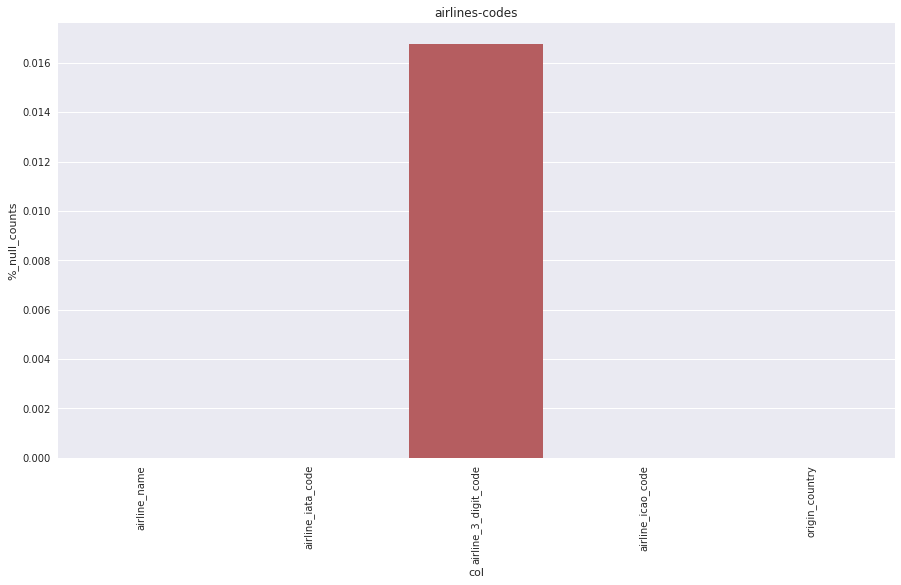

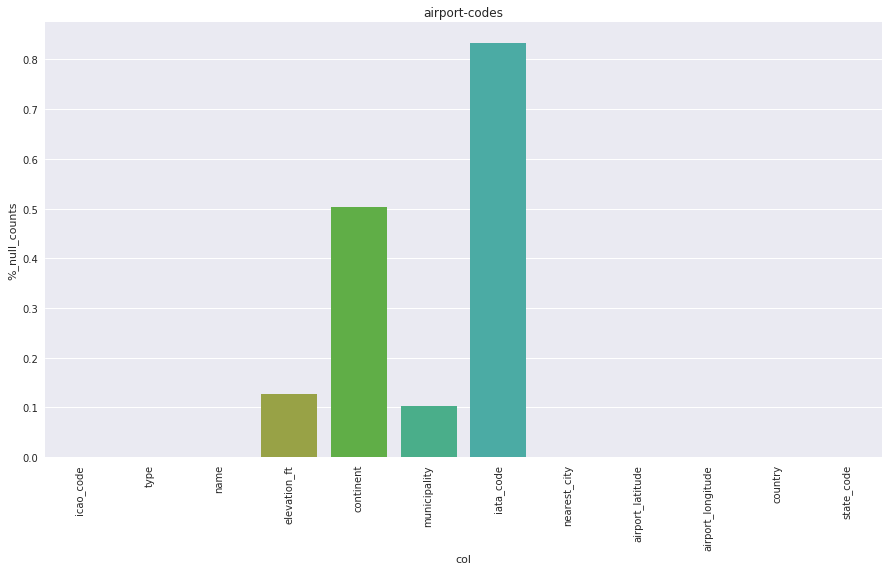

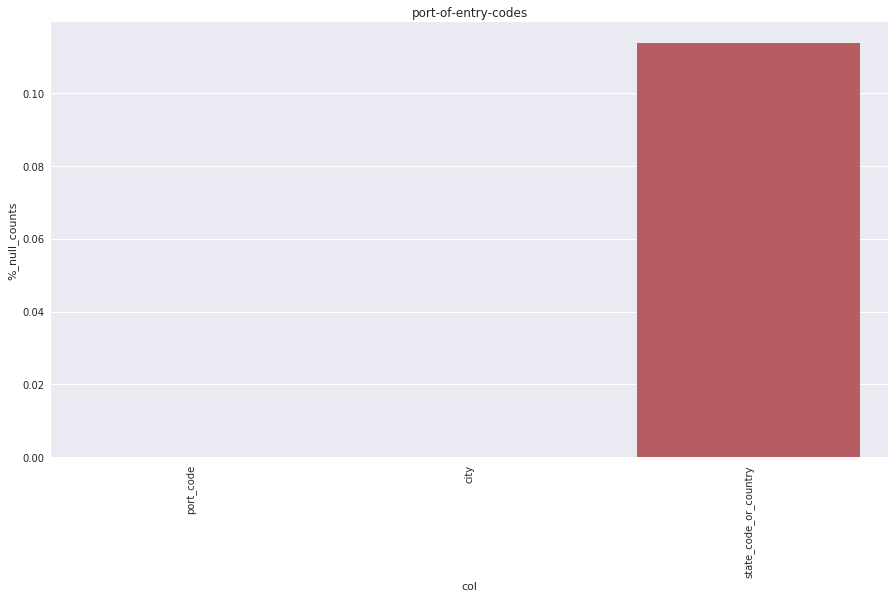

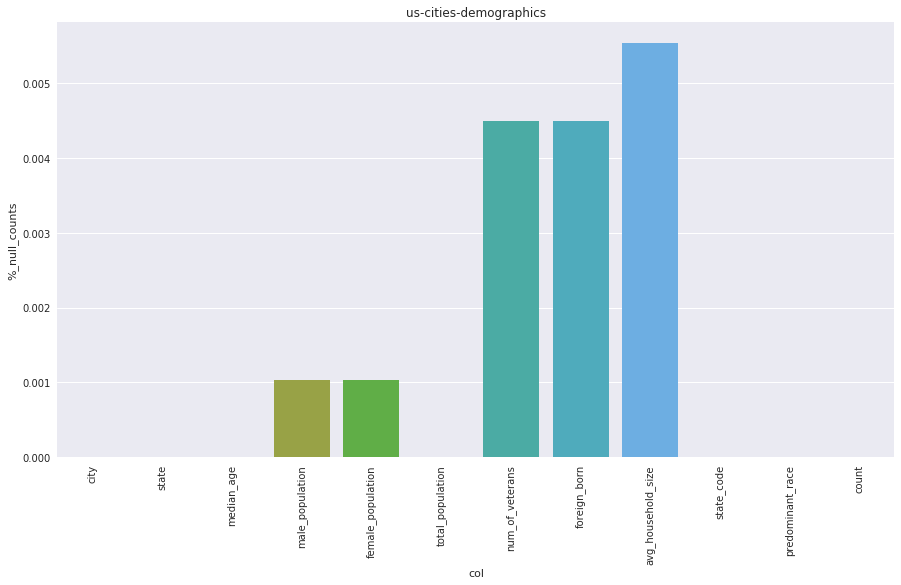

In [73]:
data_files = ['airlines-codes','airport-codes','port-of-entry-codes','us-cities-demographics','visa-issue-ports','visa-type']

for file in data_files:
    df = data_spark[file]
    null_count=df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T.reset_index()
    null_count.columns = ['col','null_counts']
    null_count['%_null_counts']=null_count['null_counts']/(df.count())
    if (null_count['%_null_counts']>0).any():
        plt.figure(figsize=(15,8))
        sns.barplot(x='col',y='%_null_counts',data=null_count)
        plt.title(file)
        plt.xticks(rotation=90)

**Observations:**
- In demographics data the % percentage of null values in the data set is very small, these rows can be dropped
- In airlines data the `airline_3_digit_code` columns has a very few number of null values, not needed to drop rows there. Can be a choice
- In airports data the `iata_code` column has high number of null values. this column can be dropped
- In port of entry codes data the `state_code_or_country` column has some null values, but this is because the data is not having any codes provided

#### Cleaning Steps
All the necessary steps I have provided in the above sections

### Step 3: Project Architecture and DWH Data Model
The following architecture is used in the project
![Project_Architecture](./AWS_Help/architechture.png)
#### 3.1 Conceptual Data Model
I used a Star schema to build the DWH in redshift and is as follows:
![Schema](./AWS_Help/data_model.png)

#### 3.2 Mapping Out Data Pipelines
To create the Data Lake and DWH the following steps are to be followed:

1. Create AWS account and fill the `dwh.cfg` file with necessary details
2. Use the data in the `data` folder and upload them into S3 bucket using the `create_resources.py` file
3. Copy the `dag` , `emr_bootstrap` folder and `plugins` folder to your `AIRFLOW` directory
4. Once the data is in place run the `capstone_meta_data_dag` to fill up a new S3 bucket which is used as a **`staging area`**
5. Run the `capstone_immigration_dag` to fill up the data lake in S3 with the SAS data
6. Run the `capstone_dwh_dag` to fill up the DWH in redshift

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

**Note: All the codes are available in the dags folder** 

#### 4.1.1 capstone_meta_data_dag 

**Note:** Run when the data is refreshed not needed to run every day, can be monthly or by trigger
**Action:** Uses the Data stored in a S3 bucket and performs all the regex operations for the I94 Labels data and other transforms needed for other data and stores the data in parquet format in a different S3 bucket which is used as staging area

![meta_data_dag](./AWS_Help/metadata_dag.png)


#### 4.1.2 capstone_immigration_dag 

**Note:** Run when the data is added monthly can be daily if the data is provided daily
**Action:** Uses the SAS Data stored in a S3 bucket and performs all the transforms needed for the data and stores it in parquet format in a different S3 bucket which is used as staging area

![meta_data_dag](./AWS_Help/immigration_data_transform.png)


#### 4.1.3 capstone_DWH_dag 

**Note:** Run when the data is added monthly can be daily if the data is provided daily
**Action:** Uses the SAS Data and other meta data stored in a staging S3 bucket and performs copy operations to AWS redshift and the data model is contrained accordingly

![meta_data_dag](./AWS_Help/dwh_dag.png)

#### 4.2 Data Quality Checks

From the data model it can be observed that the DWH tables have key constraints defined accordingly with data type and primary key when needed

Data Quality checks were included:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness

#### 4.3 Data dictionary 
I have created the data dictionary for the DWH Tables to provide column descriptions [here](./Data_Dictionary.md)

#### Step 5: Connecting to DWH and Obtaining Stats

In [1]:
!pip install pandas-redshift

  Using cached docutils-0.15.2-py3-none-any.whl (547 kB)
ERROR: apache-airflow 1.10.10 has requirement jinja2<2.11.0,>=2.10.1, but you'll have jinja2 2.11.2 which is incompatible.
ERROR: apache-airflow 1.10.10 has requirement pandas<1.0.0,>=0.17.1, but you'll have pandas 1.0.3 which is incompatible.
ERROR: apache-airflow 1.10.10 has requirement werkzeug<1.0.0, but you'll have werkzeug 1.0.1 which is incompatible.
  Attempting uninstall: docutils
    Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16


In [1]:
import pandas_redshift as pr
import matplotlib.pyplot as plt

import configparser

config = configparser.ConfigParser()
config.read_file(open('dwh.cfg'))



pr.connect_to_redshift(dbname = config.get('DWH', 'DB_NAME'),
                        host = config.get('DWH', 'HOST'),
                        port = config.get('DWH', 'DB_PORT'),
                        user = config.get('DWH', 'DB_USER'),
                        password = config.get('DWH', 'DB_PASSWORD'))

In [2]:
plt.style.use('ggplot')
import seaborn as sns

In [19]:
# number of people coming from different countries
query = """
SELECT top 10 SUBSTRING(b.country_name, 0, 15) as country_name, COUNT(cicid) as count
FROM immigration a INNER JOIN i94res b ON a.country_id=b.country_id
GROUP BY b.country_name
ORDER BY COUNT((cicid)) DESC
"""
df = pr.redshift_to_pandas(query)
df

,country_name,count
0,UNITED KINGDOM,6019081
1,JAPAN,4118737
2,"CHINA, PRC",3955056
3,MEXICO,3348981
4,FRANCE,2385333
5,BRAZIL,2200040
6,AUSTRALIA,1771403
7,INDIA,1756452
8,ITALY,1435205
9,ARGENTINA,1165643


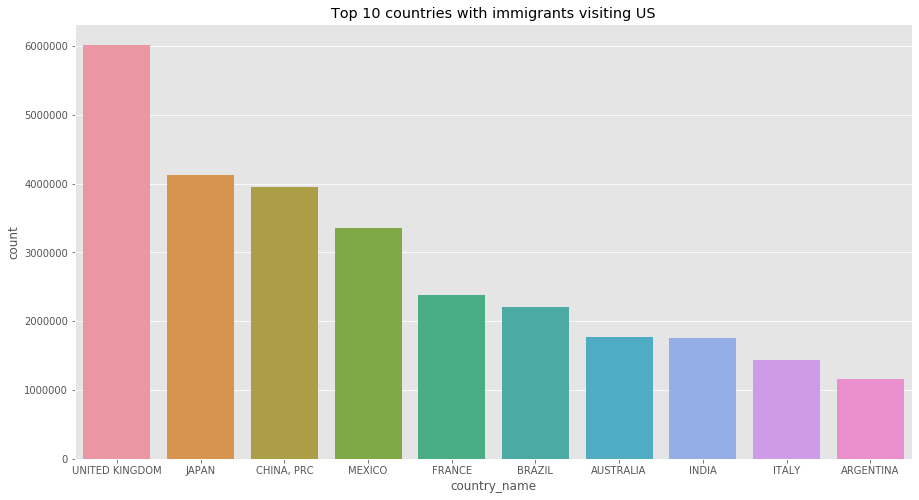

In [21]:
plt.figure(figsize=(15,8))
plt.title("Top 10 countries with immigrants visiting US")
sns.barplot(x='country_name', y='count', data=df);

In [30]:
query = """
SELECT
    im.gender,
    im.visa_type,
    count(im.cicid)
FROM immigration as im
    JOIN visa_type
    ON im.visa_type = visa_type.visa_type
GROUP BY im.gender, im.visa_type;
"""
df = pr.redshift_to_pandas(query)

Text(0.5, 1.0, 'Distribution of Visa Types across Gender in 2016')

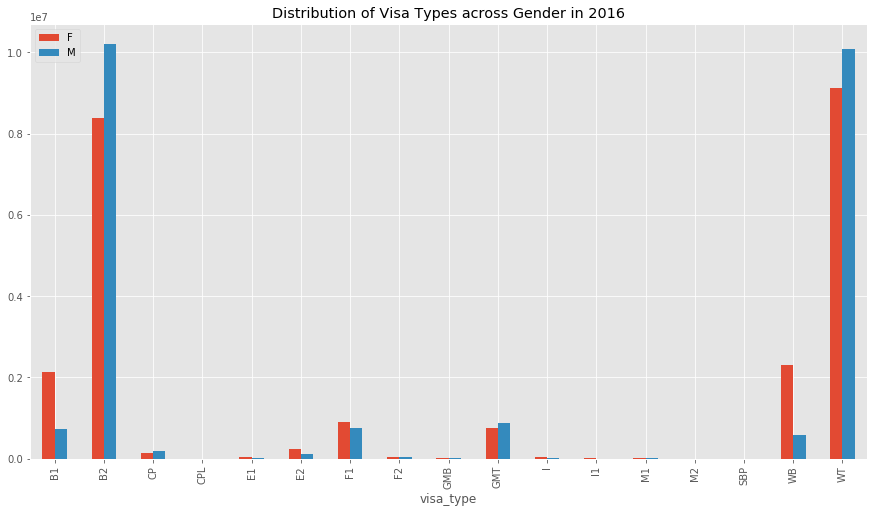

In [31]:
df = df.set_index(['visa_type', 'gender']).unstack()[[('count', 'M'),('count', 'F')]]
df.columns=['F', 'M']
df.plot(kind='bar', figsize=(15,8));
plt.title("Distribution of Visa Types across Gender in 2016")

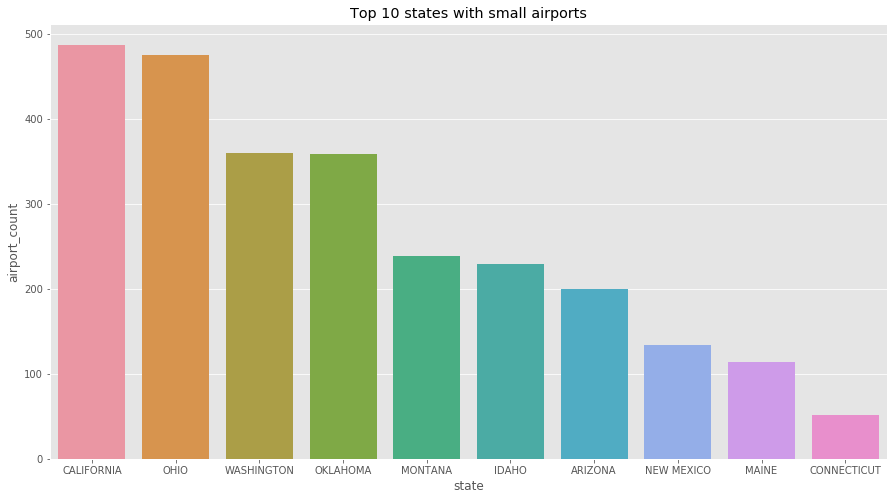

In [32]:
query="""
SELECT a.state_name AS State, airports.count AS airport_count
FROM
    (SELECT top 10 distinct state_code, count(*)
     FROM airport_codes
     WHERE country = 'US' AND airport_type='small_airport'
     GROUP BY state_code) airports INNER JOIN i94addr a ON airports.state_code=a.state_code
ORDER BY airports.count DESC;
"""

df = pr.redshift_to_pandas(query)
plt.figure(figsize=(15,8))
plt.title("Top 10 states with small airports")
sns.barplot(x='state', y='airport_count', data=df);

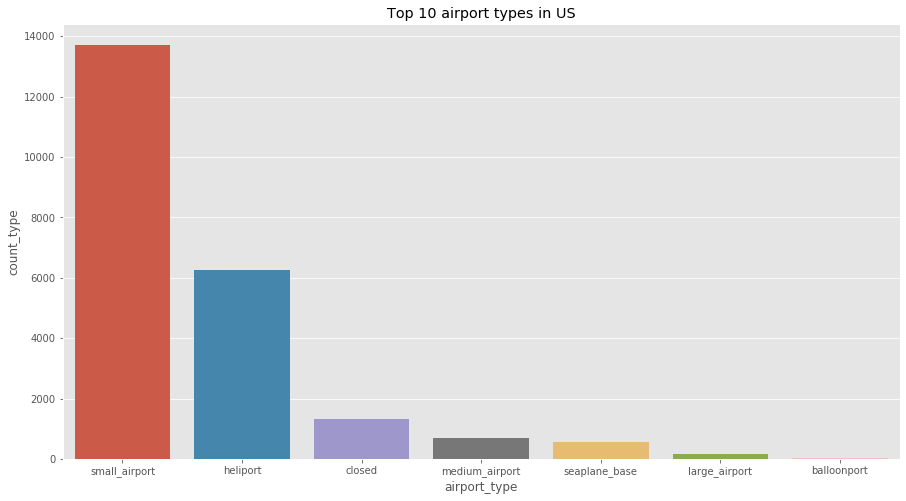

In [37]:
query="""
SELECT top 10 distinct airport_type, count(*) AS count_type
FROM airport_codes
WHERE country = 'US'
GROUP BY airport_type
ORDER BY count_type DESC;
"""
df = pr.redshift_to_pandas(query)
plt.figure(figsize=(15,8))
plt.title("Top 10 airport types in US")
sns.barplot(x='airport_type', y='count_type', data=df);

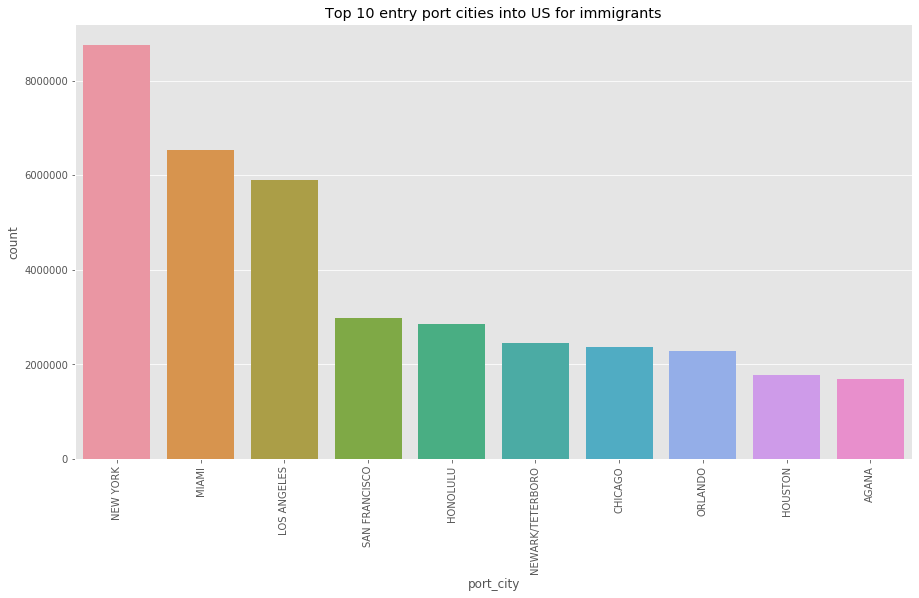

In [40]:
query="""
SELECT TOP 10 b.port_city, b.state_code_or_country, COUNT(cicid) AS count
FROM immigration a INNER JOIN i94ports b ON a.port_id=b.port_code
GROUP BY b.port_city, b.state_code_or_country
ORDER BY COUNT(cicid) DESC;
"""
df = pr.redshift_to_pandas(query)
plt.figure(figsize=(15,8))
plt.title("Top 10 entry port cities into US for immigrants")
sns.barplot(x='port_city', y='count', data=df);
plt.xticks(rotation=90);

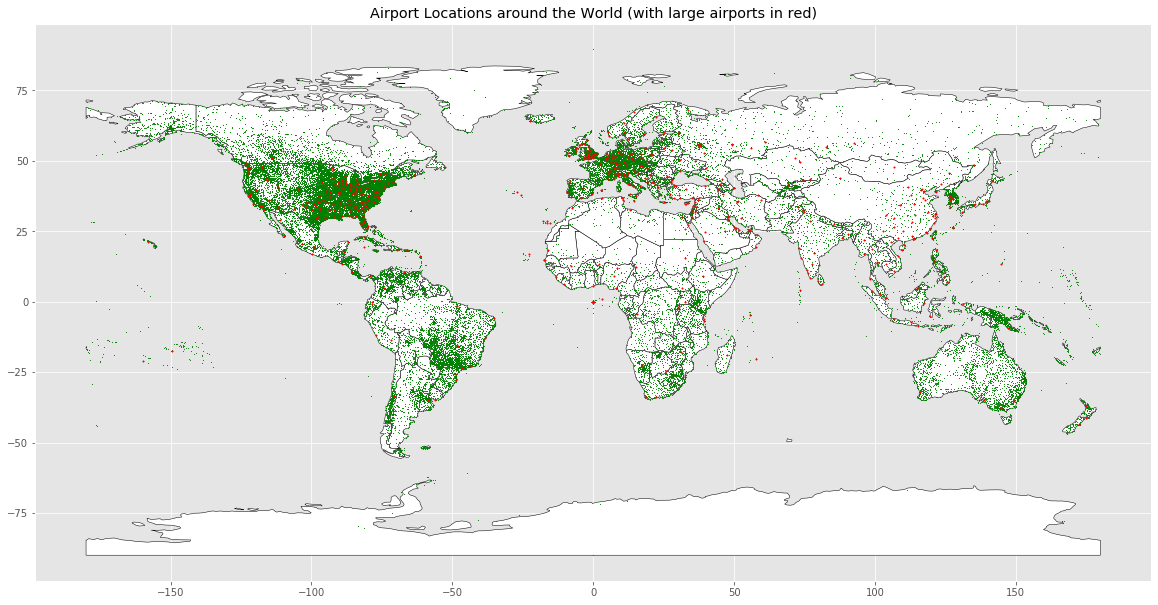

In [46]:
import geopandas
# port city from where people arrived
query = """
SELECT a.airport_longitude, a.airport_latitude
FROM airport_codes a;
"""
df = pr.redshift_to_pandas(query)

query2 = """
SELECT a.airport_longitude, a.airport_latitude
FROM airport_codes a
WHERE airport_type='large_airport';
"""
df2 = pr.redshift_to_pandas(query2)

gdf = geopandas.GeoDataFrame(
    df[['airport_longitude','airport_latitude']], 
    geometry=geopandas.points_from_xy(df.airport_longitude, 
                                      df.airport_latitude))
gdf2 = geopandas.GeoDataFrame(
    df2[['airport_longitude','airport_latitude']], 
    geometry=geopandas.points_from_xy(df2.airport_longitude, 
                                      df2.airport_latitude))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(20,15))
gdf.plot(ax=ax, color='green', markersize=0.3)
gdf2.plot(ax=ax, color='red', markersize=2.0)

plt.title("Airport Locations around the World (with large airports in red)")
plt.show();

In [3]:
query = """
SELECT a.entry_month,b.transportation_mode,COUNT(cicid) AS count
FROM immigration a INNER JOIN i94mode b ON a.mode_id=b.mode_id
WHERE a.state_code = 'CA'
GROUP BY a.entry_month, b.transportation_mode, a.entry_month
ORDER BY COUNT(cicid) DESC;
"""
df = pr.redshift_to_pandas(query)
df

,entry_month,transportation_mode,count
0,4,Air,1851856
1,5,Air,1043318
2,7,Air,739711
3,9,Air,655251
4,8,Air,654599
5,6,Air,586326
6,10,Air,551515
7,12,Air,528591
8,3,Air,464859
9,1,Air,435446


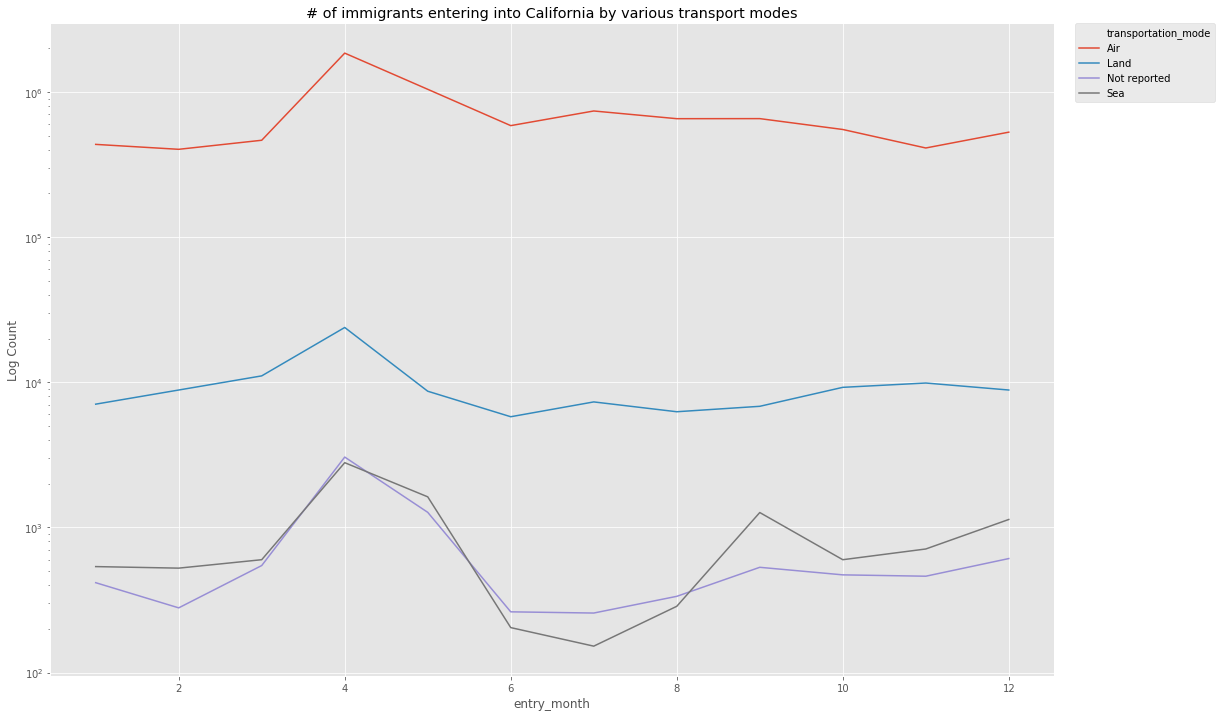

In [4]:
plt.figure(figsize=(18,12))
plt.title("# of immigrants entering into California by various transport modes")
lplot=sns.lineplot(x="entry_month", y="count", hue="transportation_mode", data=df);
plt.ylabel("Log Count")
lplot.set(yscale="log")
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);

#### Extras

##### move files to S3

In [7]:
import configparser
import boto3
import pandas as pd
from io import StringIO

config = configparser.ConfigParser()
config.read('./dwh.cfg')

AWS_ACCESS_KEY = config.get('AWS', 'AWS_KEY_ID')
AWS_SECRET = config.get('AWS','AWS_SECRET')
AWS_REGION = config.get('AWS','REGION')
S3_BUCKET = config.get('S3','BUCKET_NAME')

In [2]:
s3 = boto3.resource('s3',region_name=AWS_REGION,
                    aws_access_key_id=AWS_ACCESS_KEY,
                    aws_secret_access_key=AWS_SECRET)

In [11]:
csv_buffer = StringIO()
df_airports = pd.read_csv('airport-codes_csv.csv')
df_airports.to_csv(csv_buffer)
s3.Object(S3_BUCKET,'airport_codes/airport-codes_csv.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '19F04C1FF73127C2',
  'HostId': 'k3HL5Z2nAKNSyZzF0ZBo8r3FjGu25hPNDcYvJvoR76u3F+Anp/hMHlZq5t+TPiMYXBcrvno/zOk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'k3HL5Z2nAKNSyZzF0ZBo8r3FjGu25hPNDcYvJvoR76u3F+Anp/hMHlZq5t+TPiMYXBcrvno/zOk=',
   'x-amz-request-id': '19F04C1FF73127C2',
   'date': 'Mon, 11 May 2020 18:37:02 GMT',
   'etag': '"75285372d53b7508543b5c671383a2fe"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"75285372d53b7508543b5c671383a2fe"'}

In [12]:
df_demographics = pd.read_csv('us-cities-demographics.csv')
df_demographics.to_csv(csv_buffer)
s3.Object(S3_BUCKET,'us-demographics/us-cities-demographics.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'A7D85AA646A9DBCF',
  'HostId': 'twCyiYQxiy9gukylHvfVolx7NdbXHCWm66vW+KiyqMTcanwLyBsQDCHl+BBik3PElJ49rEeIcgw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'twCyiYQxiy9gukylHvfVolx7NdbXHCWm66vW+KiyqMTcanwLyBsQDCHl+BBik3PElJ49rEeIcgw=',
   'x-amz-request-id': 'A7D85AA646A9DBCF',
   'date': 'Mon, 11 May 2020 18:37:20 GMT',
   'etag': '"175d3f6963129a4bd9dec03c4caaa452"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"175d3f6963129a4bd9dec03c4caaa452"'}

In [ ]:
out_buffer = BytesIO()
df_i94.to_parquet(out_buffer, index=False)